In [ ]:
# Задание 1

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
print(keras.__version__)

2.15.0


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
from tensorflow import keras
from IPython.display import Image
from IPython.core.display import HTML
import matplotlib.pyplot as plt
import keras
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/lenta_40k.csv')

In [ ]:
# предобработка
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [ ]:
# f1
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# словарь
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [ ]:
len(vocab)

354611

In [ ]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [ ]:
len(filtered_vocab)

24091

In [ ]:
# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [ ]:
id2word = {i:word for word, i in word2id.items()}

In [ ]:
id2word = {i:word for word, i in word2id.items()}

In [ ]:
# переводим тексты в последовательности индексов
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [ ]:
MAX_LEN = max(len(x) for x in X)
MEAN_LEN = np.median([len(x) for x in X])
MAX_LEN = int(MEAN_LEN + 30)

In [ ]:
# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}
y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

In [ ]:
# №1 модель с 1 GRU слоем
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

rnn = tf.keras.layers.GRU(128, return_sequences=False)(embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(rnn)

model1 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model1.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1,
                       tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])
model1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 200, 30)           722790    
                                                                 
 gru_2 (GRU)                 (None, 128)               61440     
                                                                 
 dense_2 (Dense)             (None, 19)                2451      
                                                                 
Total params: 786681 (3.00 MB)
Trainable params: 786681 (3.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model1.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=5)

Epoch 1/5
43/43 [==============================] - 113s 3s/step - loss: 2.5460 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3183 - val_f1: 0.0000e+00 - val_rec@prec: 9.0171e-04
Epoch 2/5
43/43 [==============================] - 110s 3s/step - loss: 2.2651 - f1: 0.0000e+00 - rec@prec: 4.7463e-05 - val_loss: 2.1808 - val_f1: 0.0000e+00 - val_rec@prec: 0.0041
Epoch 3/5
43/43 [==============================] - 111s 3s/step - loss: 2.1013 - f1: 0.0136 - rec@prec: 0.0014 - val_loss: 2.0234 - val_f1: 0.0315 - val_rec@prec: 4.5086e-04
Epoch 4/5
43/43 [==============================] - 111s 3s/step - loss: 1.8479 - f1: 0.1237 - rec@prec: 0.0435 - val_loss: 1.8729 - val_f1: 0.1858 - val_rec@prec: 0.0207
Epoch 5/5
43/43 [==============================] - 113s 3s/step - loss: 1.6530 - f1: 0.2794 - rec@prec: 0.1291 - val_loss: 1.7075 - val_f1: 0.2820 - val_rec@prec: 0.0627


dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


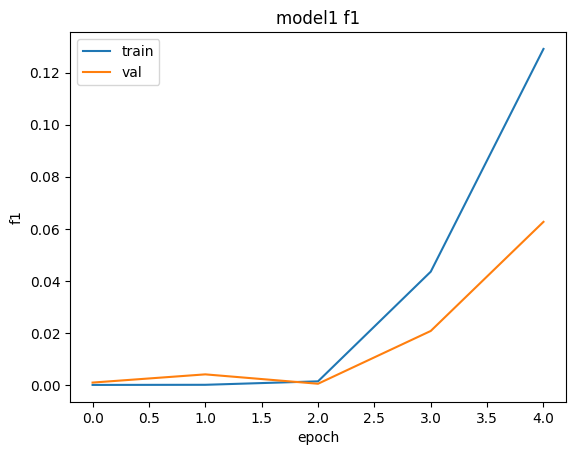

In [ ]:
print(model1.history.history.keys())
# summarize history for accuracy
plt.plot(model1.history.history['rec@prec'])
plt.plot(model1.history.history['val_rec@prec'])
plt.title('model1 f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# №2 модель с 1 LSTM слоем
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

rnn = tf.keras.layers.LSTM(128, return_sequences=False)(embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(rnn)

model2 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1,
                       tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])
model2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 200, 30)           722790    
                                                                 
 lstm_1 (LSTM)               (None, 128)               81408     
                                                                 
 dense_4 (Dense)             (None, 19)                2451      
                                                                 
Total params: 806649 (3.08 MB)
Trainable params: 806649 (3.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model2.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=5)

Epoch 1/5
43/43 [==============================] - 140s 3s/step - loss: 2.4818 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3188 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/5
43/43 [==============================] - 134s 3s/step - loss: 2.3092 - f1: 0.0000e+00 - rec@prec: 7.1195e-05 - val_loss: 2.2895 - val_f1: 0.0000e+00 - val_rec@prec: 0.0018
Epoch 3/5
43/43 [==============================] - 134s 3s/step - loss: 2.1906 - f1: 6.6445e-04 - rec@prec: 0.0020 - val_loss: 2.0272 - val_f1: 0.0020 - val_rec@prec: 0.0446
Epoch 4/5
43/43 [==============================] - 133s 3s/step - loss: 1.8404 - f1: 0.0878 - rec@prec: 0.0454 - val_loss: 1.7174 - val_f1: 0.1281 - val_rec@prec: 0.0541
Epoch 5/5
43/43 [==============================] - 134s 3s/step - loss: 1.5107 - f1: 0.3691 - rec@prec: 0.1824 - val_loss: 1.4765 - val_f1: 0.4522 - val_rec@prec: 0.2308


dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


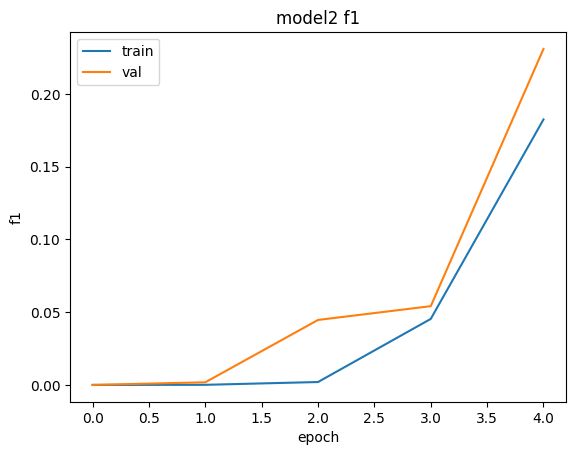

In [ ]:
print(model2.history.history.keys())
# summarize history for accuracy
plt.plot(model2.history.history['rec@prec'])
plt.plot(model2.history.history['val_rec@prec'])
plt.title('model2 f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# №3 модель с 1 GRU и 1 LSTM слоем
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm_1 = tf.keras.layers.LSTM(128, return_sequences=True)(embeddings)
lstm_2 = tf.keras.layers.GRU(128, return_sequences=False)(lstm_1)

dense = tf.keras.layers.Dense(64, activation='relu')(lstm_2)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model3 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model3.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

model3.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 200, 30)           722790    
                                                                 
 lstm_2 (LSTM)               (None, 200, 128)          81408     
                                                                 
 gru_3 (GRU)                 (None, 128)               99072     
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 19)                1235      
                                                                 
Total params: 912761 (3.48 MB)
Trainable params: 912761 (3.

In [ ]:
model3.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=200,
          epochs=10)

Epoch 1/10
211/211 [==============================] - 352s 2s/step - loss: 2.1760 - f1: 0.0471 - rec@prec: 0.0227 - val_loss: 1.7079 - val_f1: 0.1313 - val_rec@prec: 0.0920
Epoch 2/10
211/211 [==============================] - 345s 2s/step - loss: 1.4218 - f1: 0.4502 - rec@prec: 0.2932 - val_loss: 1.2610 - val_f1: 0.5480 - val_rec@prec: 0.4328
Epoch 3/10
211/211 [==============================] - 340s 2s/step - loss: 1.0353 - f1: 0.6656 - rec@prec: 0.5804 - val_loss: 1.0664 - val_f1: 0.6550 - val_rec@prec: 0.5568
Epoch 4/10
211/211 [==============================] - 352s 2s/step - loss: 0.7481 - f1: 0.7733 - rec@prec: 0.7636 - val_loss: 0.9978 - val_f1: 0.7062 - val_rec@prec: 0.6114
Epoch 5/10
211/211 [==============================] - 349s 2s/step - loss: 0.5441 - f1: 0.8393 - rec@prec: 0.8675 - val_loss: 1.0690 - val_f1: 0.7100 - val_rec@prec: 0.6109
Epoch 6/10
211/211 [==============================] - 349s 2s/step - loss: 0.4284 - f1: 0.8750 - rec@prec: 0.9164 - val_loss: 1.0923 - 

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


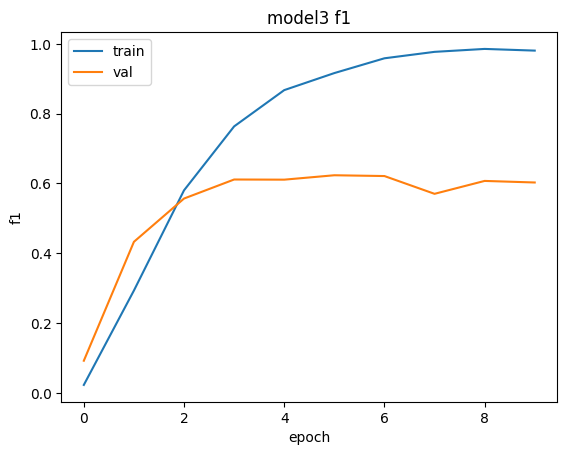

In [ ]:
print(model3.history.history.keys())
# summarize history for accuracy
plt.plot(model3.history.history['rec@prec'])
plt.plot(model3.history.history['val_rec@prec'])
plt.title('model3 f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# №4 модель с 1 BIGRU и 2 LSTM слоями
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddings)

lstm_1 = tf.keras.layers.LSTM(128, return_sequences=True)(gru)
lstm_2 = tf.keras.layers.LSTM(128, return_sequences=False)(lstm_1)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm_2)

model4 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model4.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

model4.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_7 (Embedding)     (None, 200, 30)           722790    
                                                                 
 bidirectional_1 (Bidirecti  (None, 200, 256)          122880    
 onal)                                                           
                                                                 
 lstm_5 (LSTM)               (None, 200, 128)          197120    
                                                                 
 lstm_6 (LSTM)               (None, 128)               131584    
                                                                 
 dense_8 (Dense)             (None, 19)                2451      
                                                           

In [ ]:
model4.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=200,
          epochs=10)

Epoch 1/10
211/211 [==============================] - 825s 4s/step - loss: 2.1028 - f1: 0.0862 - rec@prec: 0.0420 - val_loss: 1.5501 - val_f1: 0.2926 - val_rec@prec: 0.1668
Epoch 2/10
211/211 [==============================] - 818s 4s/step - loss: 1.4042 - f1: 0.4422 - rec@prec: 0.2565 - val_loss: 1.3498 - val_f1: 0.5025 - val_rec@prec: 0.3233
Epoch 3/10
211/211 [==============================] - 814s 4s/step - loss: 1.1355 - f1: 0.6147 - rec@prec: 0.4645 - val_loss: 1.2502 - val_f1: 0.5792 - val_rec@prec: 0.4206
Epoch 4/10
211/211 [==============================] - 763s 4s/step - loss: 0.9657 - f1: 0.6931 - rec@prec: 0.6107 - val_loss: 1.1385 - val_f1: 0.6248 - val_rec@prec: 0.4928
Epoch 5/10
211/211 [==============================] - 753s 4s/step - loss: 0.8107 - f1: 0.7529 - rec@prec: 0.7286 - val_loss: 1.0142 - val_f1: 0.6846 - val_rec@prec: 0.5992
Epoch 6/10
211/211 [==============================] - 750s 4s/step - loss: 0.6887 - f1: 0.7961 - rec@prec: 0.7993 - val_loss: 0.9834 - 

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


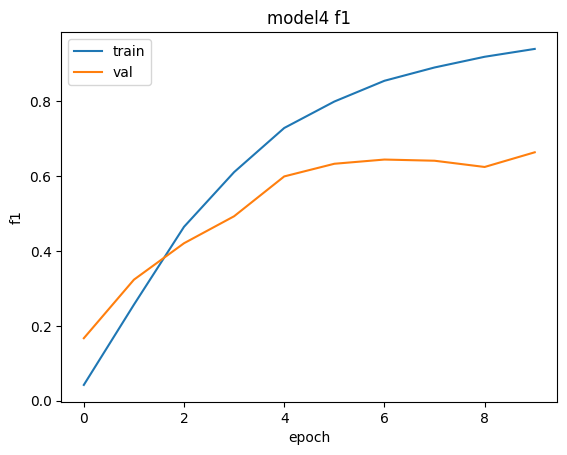

In [ ]:
print(model4.history.history.keys())
# summarize history for accuracy
plt.plot(model4.history.history['rec@prec'])
plt.plot(model4.history.history['val_rec@prec'])
plt.title('model4 f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# №5 модель с 5 GRU слоями и 3 LSTM слоями
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

gru1 = keras.layers.GRU(128, return_sequences=True)(embeddings)
gru2 = keras.layers.GRU(128, return_sequences=True)(gru1)
lstm1 = keras.layers.LSTM(128, return_sequences=True)(gru2)
gru3 = keras.layers.GRU(128, return_sequences=True)(lstm1)
lstm2 = keras.layers.LSTM(128, return_sequences=True)(gru3)
gru4 = keras.layers.GRU(128, return_sequences=True)(lstm2)
lstm3 = keras.layers.LSTM(128, return_sequences=True)(gru4)
gru5 = keras.layers.GRU(128, return_sequences=False)(gru4)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(gru5)

model5 = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam()
model5.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])
model5.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 200, 30)           722790    
                                                                 
 gru_1 (GRU)                 (None, 200, 128)          61440     
                                                                 
 gru_2 (GRU)                 (None, 200, 128)          99072     
                                                                 
 lstm_1 (LSTM)               (None, 200, 128)          131584    
                                                                 
 gru_3 (GRU)                 (None, 200, 128)          99072     
                                                                 
 lstm_2 (LSTM)               (None, 200, 128)          1315

In [ ]:
model5.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=200,
          epochs=5)

Epoch 1/5
211/211 [==============================] - 1425s 7s/step - loss: 2.0793 - rec@prec: 0.0167 - val_loss: 1.7378 - val_rec@prec: 0.0717
Epoch 2/5
211/211 [==============================] - 1385s 7s/step - loss: 1.4613 - rec@prec: 0.1768 - val_loss: 1.3517 - val_rec@prec: 0.2435
Epoch 3/5
211/211 [==============================] - 1367s 6s/step - loss: 1.0974 - rec@prec: 0.4151 - val_loss: 1.2092 - val_rec@prec: 0.4026
Epoch 4/5
211/211 [==============================] - 1397s 7s/step - loss: 0.8610 - rec@prec: 0.6248 - val_loss: 1.0716 - val_rec@prec: 0.5442
Epoch 5/5
211/211 [==============================] - 1405s 7s/step - loss: 0.6532 - rec@prec: 0.7976 - val_loss: 1.0497 - val_rec@prec: 0.6069


dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


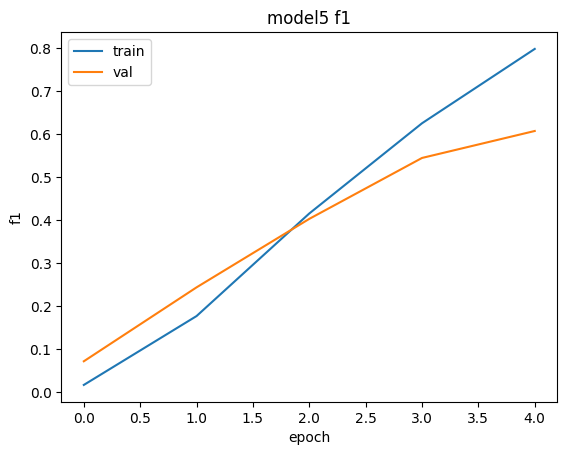

In [ ]:
print(model5.history.history.keys())
# summarize history for accuracy
plt.plot(model5.history.history['rec@prec'])
plt.plot(model5.history.history['val_rec@prec'])
plt.title('model5 f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# №6 модель 1 BIGRU и 1 BILSTM слоями (модели для forward и backward прохода должны отличаться)
inputs = tf.keras.layers.Input(shape=MAX_LEN)
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs)

BIGRU = tf.keras.layers.Bidirectional(
    tf.keras.layers.GRU(128, return_sequences=False))(embeddings)

BILSTM = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(128, return_sequences=False, go_backwards=True))(embeddings)

hidden = tf.keras.layers.concatenate([BIGRU,BILSTM])

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(hidden)

model6 = tf.keras.Model(inputs=inputs, outputs=outputs)

model6.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])
model6.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 200, 30)              722790    ['input_1[0][0]']             
                                                                                                  
 bidirectional (Bidirection  (None, 256)                  122880    ['embedding[0][0]']           
 al)                                                                                              
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 256)                  162816    ['embedding[0][0]']       

In [ ]:
model6.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=200,
          epochs=10)

Epoch 1/10
211/211 [==============================] - 652s 3s/step - loss: 2.2470 - f1: 9.3171e-05 - rec@prec: 0.0000e+00 - val_loss: 2.1801 - val_f1: 8.2508e-04 - val_rec@prec: 0.0000e+00
Epoch 2/10
211/211 [==============================] - 636s 3s/step - loss: 1.8661 - f1: 0.0423 - rec@prec: 0.0072 - val_loss: 1.8864 - val_f1: 0.1437 - val_rec@prec: 0.0721
Epoch 3/10
211/211 [==============================] - 629s 3s/step - loss: 1.6153 - f1: 0.2058 - rec@prec: 0.0827 - val_loss: 1.5238 - val_f1: 0.3645 - val_rec@prec: 0.1483
Epoch 4/10
211/211 [==============================] - 628s 3s/step - loss: 1.3798 - f1: 0.4692 - rec@prec: 0.2234 - val_loss: 1.3399 - val_f1: 0.5175 - val_rec@prec: 0.3102
Epoch 5/10
211/211 [==============================] - 637s 3s/step - loss: 1.1635 - f1: 0.6134 - rec@prec: 0.4462 - val_loss: 1.2008 - val_f1: 0.6414 - val_rec@prec: 0.4887
Epoch 6/10
211/211 [==============================] - 639s 3s/step - loss: 0.9929 - f1: 0.6893 - rec@prec: 0.6053 - val

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


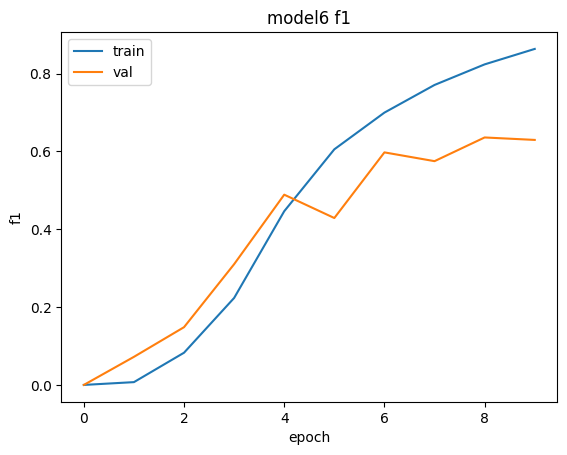

In [ ]:
print(model6.history.history.keys())
# summarize history for accuracy
plt.plot(model6.history.history['rec@prec'])
plt.plot(model6.history.history['val_rec@prec'])
plt.title('model6 f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# №7 модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm_1 = tf.keras.layers.LSTM(128, return_sequences=True)(embeddings)
gru_1 = tf.keras.layers.GRU(128, return_sequences=True)(lstm_1)
bilstm = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(128, return_sequences=True))(gru_1)
bigru = tf.keras.layers.Bidirectional(
    tf.keras.layers.GRU(128, return_sequences=True))(bilstm)
gru_2 = tf.keras.layers.GRU(128, return_sequences=True)(bigru)
lstm_2 = tf.keras.layers.LSTM(128, return_sequences=False)(gru_2)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm_2)

model7 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model7.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

model7.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 200, 30)           722790    
                                                                 
 lstm_4 (LSTM)               (None, 200, 128)          81408     
                                                                 
 gru_6 (GRU)                 (None, 200, 128)          99072     
                                                                 
 bidirectional_2 (Bidirecti  (None, 200, 256)          263168    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 200, 256)          296448    
 onal)                                                     

In [27]:
model7.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=200,
          epochs=5)

Epoch 1/5
211/211 [==============================] - 1849s 9s/step - loss: 2.0124 - f1: 0.0583 - rec@prec: 0.0243 - val_loss: 1.7006 - val_f1: 0.1638 - val_rec@prec: 0.0843
Epoch 2/5
211/211 [==============================] - 1817s 9s/step - loss: 1.5595 - f1: 0.2883 - rec@prec: 0.1171 - val_loss: 1.6137 - val_f1: 0.4175 - val_rec@prec: 0.1195
Epoch 3/5
211/211 [==============================] - 1831s 9s/step - loss: 1.2973 - f1: 0.5536 - rec@prec: 0.2338 - val_loss: 1.3185 - val_f1: 0.5679 - val_rec@prec: 0.2795
Epoch 4/5
211/211 [==============================] - 1836s 9s/step - loss: 1.0948 - f1: 0.6307 - rec@prec: 0.4442 - val_loss: 1.2459 - val_f1: 0.5793 - val_rec@prec: 0.3512
Epoch 5/5
211/211 [==============================] - 1835s 9s/step - loss: 0.9693 - f1: 0.6803 - rec@prec: 0.5692 - val_loss: 1.3458 - val_f1: 0.5811 - val_rec@prec: 0.3774


dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


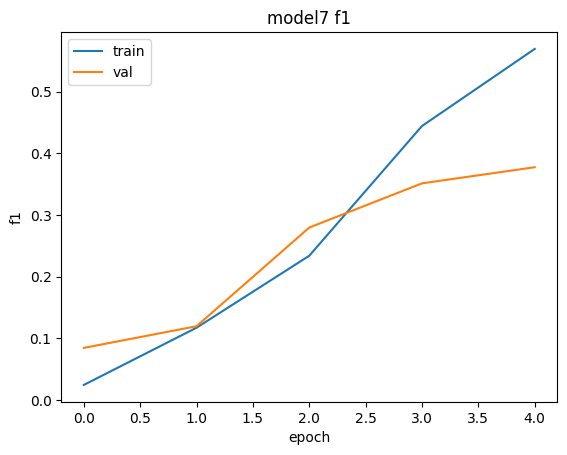

In [28]:
print(model7.history.history.keys())
# summarize history for accuracy
plt.plot(model7.history.history['rec@prec'])
plt.plot(model7.history.history['val_rec@prec'])
plt.title('model7 f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Итог: Победила первая модель

In [ ]:
# Задание 2

In [29]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.1 MB/s eta 0:00:00


In [30]:
from datasets import load_dataset

In [31]:
dataset = load_dataset("wikiann", 'ru')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [32]:
# словарь
vocab = Counter()

for sent in dataset['train']['tokens']:
    vocab.update([x.lower() for x in sent])

In [33]:
# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

In [34]:
# переводим тексты в последовательности индексов
X = []

for sent in dataset['train']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [35]:
# переводим тексты из ТЕСТА в последовательности индексов
X_test = []

for sent in dataset['test']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_test.append(ids)

In [36]:
MAX_LEN = max(len(x) for x in X)

In [38]:
# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN, padding='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

id2labels = {0:'O', 1:'B-PER', 2:'I-PER', 3:'B-ORG', 4:'I-ORG', 5: 'B-LOC', 6:'I-LOC', 7:'PAD'}
label2id = {v:k for k,v in id2labels.items()}

y = tf.keras.preprocessing.sequence.pad_sequences(dataset['train']['ner_tags'], value=7,
                                                  maxlen=MAX_LEN,  padding='post')
y_test = tf.keras.preprocessing.sequence.pad_sequences(dataset['test']['ner_tags'], value=7,
                                                       maxlen=MAX_LEN,  padding='post')

In [39]:
import gensim.downloader

In [40]:
glove_vectors = gensim.downloader.load('word2vec-ruscorpora-300')

[==================================================] 100.0% 198.8/198.8MB downloaded


In [42]:
# модель, в которой будут использованы предобученные эмбединги слов и несколько BILSTM слоев
inputs = tf.keras.layers.Input(shape=MAX_LEN)
embeddings = tf.keras.layers.Embedding(input_dim=glove_vectors.vectors.shape[0],
                                       output_dim=300,
                                       weights=[glove_vectors.vectors],
                                       input_length=MAX_LEN, trainable=False) (inputs)

BISTLM1 = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(embeddings)
BISTLM2 = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(BISTLM1)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax') (BISTLM2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [43]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 54)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 54, 300)           55491900  
                                                                 
 bidirectional_4 (Bidirecti  (None, 54, 256)           439296    
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 54, 256)           394240    
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 54, 8)             2056      
                                                                 
Total params: 56327492 (214.87 MB)
Trainable params: 835592

In [44]:
model.fit(X, y,
          validation_data=(X_test, y_test),
          batch_size=128, epochs=5)

Epoch 1/5
157/157 [==============================] - 220s 1s/step - loss: 0.2243 - accuracy: 0.9337 - val_loss: 0.1490 - val_accuracy: 0.9524
Epoch 2/5
157/157 [==============================] - 207s 1s/step - loss: 0.1280 - accuracy: 0.9590 - val_loss: 0.1142 - val_accuracy: 0.9630
Epoch 3/5
157/157 [==============================] - 207s 1s/step - loss: 0.0998 - accuracy: 0.9671 - val_loss: 0.0932 - val_accuracy: 0.9696
Epoch 4/5
157/157 [==============================] - 208s 1s/step - loss: 0.0876 - accuracy: 0.9710 - val_loss: 0.0870 - val_accuracy: 0.9721
Epoch 5/5
157/157 [==============================] - 206s 1s/step - loss: 0.0811 - accuracy: 0.9731 - val_loss: 0.0840 - val_accuracy: 0.9728


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


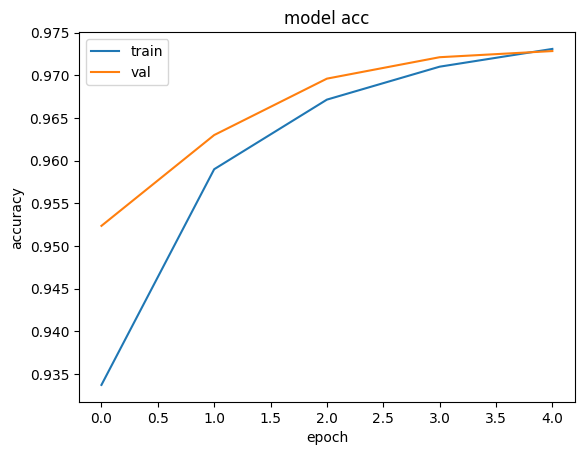

In [45]:
print(model.history.history.keys())
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [53]:
from sklearn.metrics import classification_report


pred = model.predict(X_test).argmax(2)

print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

313/313 [==============================] - 67s 216ms/step
              precision    recall  f1-score   support

           O       0.81      0.96      0.88     40480
       B-PER       0.90      0.74      0.81      3542
       I-PER       0.90      0.84      0.87      7544
       B-ORG       0.68      0.29      0.40      4074
       I-ORG       0.73      0.51      0.60      8008
       B-LOC       0.57      0.48      0.52      4560
       I-LOC       0.61      0.48      0.54      3060
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.97    540000
   macro avg       0.78      0.66      0.70    540000
weighted avg       0.97      0.97      0.97    540000



In [46]:
# модель в которой будут использованы предобученные эмбединги слов и несколько BIGRU слоев
inputs = tf.keras.layers.Input(shape=MAX_LEN)
embeddings = tf.keras.layers.Embedding(input_dim=glove_vectors.vectors.shape[0],
                                       output_dim=300, weights=[glove_vectors.vectors],
                                       input_length=MAX_LEN, trainable=False) (inputs)

BIGRU1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddings)
BIGRU2 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(BIGRU1)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax') (BIGRU2)

model_2 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [47]:
model_2.fit(X, y,
          validation_data=(X_test, y_test),
          batch_size=128, epochs=5)

Epoch 1/5
157/157 [==============================] - 197s 1s/step - loss: 0.2167 - accuracy: 0.9369 - val_loss: 0.1277 - val_accuracy: 0.9586
Epoch 2/5
157/157 [==============================] - 175s 1s/step - loss: 0.1056 - accuracy: 0.9648 - val_loss: 0.0957 - val_accuracy: 0.9687
Epoch 3/5
157/157 [==============================] - 157s 999ms/step - loss: 0.0868 - accuracy: 0.9711 - val_loss: 0.0892 - val_accuracy: 0.9712
Epoch 4/5
157/157 [==============================] - 174s 1s/step - loss: 0.0797 - accuracy: 0.9735 - val_loss: 0.0866 - val_accuracy: 0.9723
Epoch 5/5
157/157 [==============================] - 173s 1s/step - loss: 0.0747 - accuracy: 0.9753 - val_loss: 0.0883 - val_accuracy: 0.9711


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


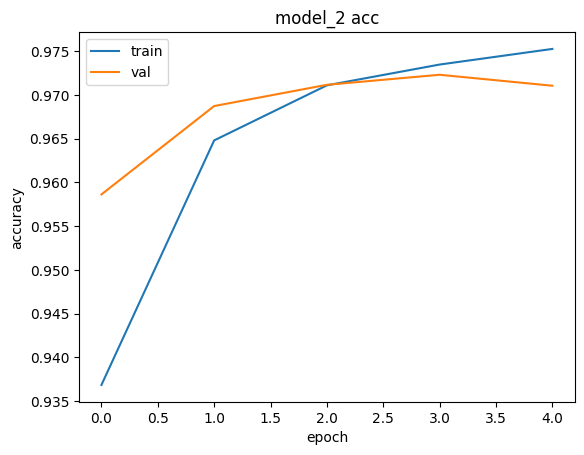

In [48]:
print(model_2.history.history.keys())
plt.plot(model_2.history.history['accuracy'])
plt.plot(model_2.history.history['val_accuracy'])
plt.title('model_2 acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [54]:
pred = model_2.predict(X_test).argmax(2)

print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

313/313 [==============================] - 47s 144ms/step
              precision    recall  f1-score   support

           O       0.87      0.89      0.88     40480
       B-PER       0.93      0.71      0.81      3542
       I-PER       0.95      0.80      0.87      7544
       B-ORG       0.64      0.33      0.44      4074
       I-ORG       0.67      0.59      0.63      8008
       B-LOC       0.43      0.62      0.51      4560
       I-LOC       0.43      0.63      0.51      3060
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.97    540000
   macro avg       0.74      0.70      0.70    540000
weighted avg       0.97      0.97      0.97    540000



In [ ]:
# сравнение двух моделей

In [51]:
import re

def tokenize(text, word2id):
    # токенизирует и переводит в индексы
    tokens = re.findall('\w+|[^\w\s]+', text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    # декодирует индексы в части речи
    # length нужно чтобы откидывать паддинги или некорректные предсказания
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(tf.keras.preprocessing.sequence.pad_sequences([ids],
                                                                       maxlen=max_len,
                                                                       padding='post'))
    labels = pred2tags(pred, id2label, len(ids))

    return list(zip(tokens, labels))

In [55]:
 # BILSTM
label_seq('Дмитрий чувствует, что успешно продвигается к выполнению задачи.', word2id, id2labels, MAX_LEN, model)

1/1 [==============================] - 0s 107ms/step


[('Дмитрий', 'O'),
 ('чувствует', 'O'),
 (',', 'O'),
 ('что', 'O'),
 ('успешно', 'O'),
 ('продвигается', 'O'),
 ('к', 'O'),
 ('выполнению', 'O'),
 ('задачи', 'O'),
 ('.', 'O')]

In [56]:
 # BILSTM
label_seq('Любовь к человеку делает лучше вашу жизнь.', word2id, id2labels, MAX_LEN, model)

1/1 [==============================] - 0s 49ms/step


[('Любовь', 'O'),
 ('к', 'O'),
 ('человеку', 'O'),
 ('делает', 'O'),
 ('лучше', 'O'),
 ('вашу', 'O'),
 ('жизнь', 'O'),
 ('.', 'O')]

In [57]:
 # BIGRU
label_seq('Дмитрий чувствует, что успешно продвигается к выполнению задачи', word2id, id2labels, MAX_LEN, model_2)

1/1 [==============================] - 0s 49ms/step


[('Дмитрий', 'O'),
 ('чувствует', 'O'),
 (',', 'O'),
 ('что', 'O'),
 ('успешно', 'I-ORG'),
 ('продвигается', 'I-ORG'),
 ('к', 'I-ORG'),
 ('выполнению', 'I-ORG'),
 ('задачи', 'I-ORG')]

In [58]:
 # BIGRU
label_seq('Любовь к человеку делает лучше вашу жизнь.', word2id, id2labels, MAX_LEN, model_2)

1/1 [==============================] - 0s 243ms/step


[('Любовь', 'O'),
 ('к', 'O'),
 ('человеку', 'O'),
 ('делает', 'O'),
 ('лучше', 'B-ORG'),
 ('вашу', 'I-ORG'),
 ('жизнь', 'I-ORG'),
 ('.', 'O')]

In [ ]:
# Вывод: кажется, произошла ошибка и сущности лишь частично определяются. Однако по classification_report могу сделать вывод, что обе модели неплохо работают